In [4]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0=malignant, 1=benign in this dataset

print("X shape:", X.shape)
print("Target distribution:\n", y.value_counts())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Baseline model with probabilities
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1

# Metrics
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
}
print("Metrics:", metrics)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Save outputs for Month 2 (3-way decisions)
out = X_test.copy()
out["y_true"] = y_test.values
out["y_pred"] = y_pred
out["p_class1"] = y_proba

out.to_csv("../results/baseline_test_predictions.csv", index=False)
pd.DataFrame([metrics]).to_csv("../results/baseline_metrics.csv", index=False)

print("Saved: results/baseline_test_predictions.csv and results/baseline_metrics.csv")


X shape: (569, 30)
Target distribution:
 target
1    357
0    212
Name: count, dtype: int64
Metrics: {'accuracy': 0.9824561403508771, 'precision': 0.9861111111111112, 'recall': 0.9861111111111112, 'f1': 0.9861111111111112}
Confusion matrix:
 [[41  1]
 [ 1 71]]
Saved: results/baseline_test_predictions.csv and results/baseline_metrics.csv


In [6]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent  # because notebook is in /notebooks
sys.path.append(str(PROJECT_ROOT))

from src.three_way import evaluate_three_way



In [7]:
import pandas as pd
from src.load_wdbc import load_uci_wdbc

X, y, ids = load_uci_wdbc("../data/raw/wdbc.data")

print("X shape:", X.shape)
print("Target distribution:\n", y.value_counts())


X shape: (569, 30)
Target distribution:
 1
1    357
0    212
Name: count, dtype: int64


In [14]:
import pandas as pd
from src.three_way import evaluate_three_way

df = pd.read_csv("../results/baseline_test_predictions.csv")

# Try some starter thresholds
for (a, b) in [(0.95, 0.05), (0.90, 0.10), (0.85, 0.15)]:
    print(evaluate_three_way(df, alpha=a, beta=b))



{'alpha': 0.95, 'beta': 0.05, 'coverage': 0.7894736842105263, 'n_total': 114, 'n_non_uncertain': 90, 'accuracy_non_uncertain': np.float64(1.0)}
{'alpha': 0.9, 'beta': 0.1, 'coverage': 0.868421052631579, 'n_total': 114, 'n_non_uncertain': 99, 'accuracy_non_uncertain': np.float64(0.98989898989899)}
{'alpha': 0.85, 'beta': 0.15, 'coverage': 0.9122807017543859, 'n_total': 114, 'n_non_uncertain': 104, 'accuracy_non_uncertain': np.float64(0.9903846153846154)}


Saved: results/three_way_sweep.csv


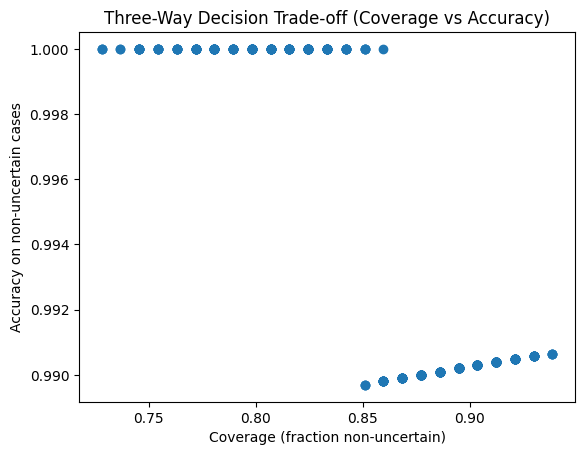

,alpha,beta,coverage,n_total,n_non_uncertain,accuracy_non_uncertain
227,0.91,0.19,0.859649,114,98,1.0
225,0.91,0.17,0.850877,114,97,1.0
226,0.91,0.18,0.850877,114,97,1.0
246,0.92,0.19,0.850877,114,97,1.0
265,0.93,0.19,0.850877,114,97,1.0
222,0.91,0.14,0.842105,114,96,1.0
223,0.91,0.15,0.842105,114,96,1.0
224,0.91,0.16,0.842105,114,96,1.0
244,0.92,0.17,0.842105,114,96,1.0
245,0.92,0.18,0.842105,114,96,1.0


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.three_way import evaluate_three_way

df = pd.read_csv("../results/baseline_test_predictions.csv")

results = []
alphas = np.arange(0.80, 0.99, 0.01)
betas  = np.arange(0.01, 0.20, 0.01)

for a in alphas:
    for b in betas:
        if b < a:  # must be valid three-way region
            results.append(evaluate_three_way(df, alpha=float(a), beta=float(b)))

res_df = pd.DataFrame(results)

# Save the sweep
res_df.to_csv("../results/three_way_sweep.csv", index=False)
print("Saved: results/three_way_sweep.csv")

# Plot: coverage vs accuracy_non_uncertain
plt.figure()
plt.scatter(res_df["coverage"], res_df["accuracy_non_uncertain"])
plt.xlabel("Coverage (fraction non-uncertain)")
plt.ylabel("Accuracy on non-uncertain cases")
plt.title("Three-Way Decision Trade-off (Coverage vs Accuracy)")
plt.show()

# Show top options: maximize accuracy first, then coverage
top = res_df.sort_values(["accuracy_non_uncertain", "coverage"], ascending=[False, False]).head(10)
top


In [16]:
import pandas as pd
from src.three_way import apply_three_way

alpha, beta = 0.91, 0.19

df = pd.read_csv("../results/baseline_test_predictions.csv")
df["decision"] = apply_three_way(df["p_class1"], alpha=alpha, beta=beta)

# Save final labeled file
df.to_csv("../results/test_with_three_way_labels.csv", index=False)

print(df["decision"].value_counts())


decision
Confirm_Benign       58
Confirm_Malignant    40
Uncertain            16
Name: count, dtype: int64


In [17]:
non_unc = df[df["decision"] != "Uncertain"].copy()

# map decision to predicted class
non_unc["y_3wd"] = non_unc["decision"].map({
    "Confirm_Benign": 1,
    "Confirm_Malignant": 0
})

errors = non_unc[non_unc["y_3wd"] != non_unc["y_true"]]
print("Non-uncertain cases:", len(non_unc))
print("Errors in non-uncertain:", len(errors))

errors.head()


Non-uncertain cases: 98
Errors in non-uncertain: 0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y_true,y_pred,p_class1,decision,y_3wd


In [12]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 1=benign, 0=malignant
df_full = pd.concat([X, y], axis=1)

df_full.to_csv("../data/raw/breast_cancer_dataset.csv", index=False)
print("Saved: data/raw/breast_cancer_dataset.csv")


Saved: data/raw/breast_cancer_dataset.csv


In [13]:
df_full = X.copy()
df_full["diagnosis"] = y.map({1:"B", 0:"M"})
df_full["id"] = ids
df_full.to_csv("../data/raw/wdbc_clean.csv", index=False)
print("Saved: data/raw/wdbc_clean.csv")


Saved: data/raw/wdbc_clean.csv
